In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("./data/cleaned_AEP_hourly.csv", parse_dates=[0], index_col=[0])
df.head()

,AEP_MW,Baseline
Datetime,,
2004-10-02 01:00:00,12260.0,12379.0
2004-10-02 02:00:00,11672.0,11935.0
2004-10-02 03:00:00,11352.0,11692.0
2004-10-02 04:00:00,11177.0,11597.0
2004-10-02 05:00:00,11142.0,11681.0


In [2]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.day_of_week
df['month'] = df.index.month

df['lag1'] = df['AEP_MW'].shift(1)
df['lag24'] = df['AEP_MW'].shift(24)

df['rolling24'] = df['AEP_MW'].shift(24).rolling(window=24).mean()

df = df.dropna()
df.head()

,AEP_MW,Baseline,hour,dayofweek,month,lag1,lag24,rolling24
Datetime,,,,,,,,
2004-10-04 00:00:00,12351.0,12172.0,0,0,10,13132.0,12172.0,12959.250000
2004-10-04 01:00:00,11817.0,11443.0,1,0,10,12351.0,11443.0,12925.208333
2004-10-04 02:00:00,11408.0,10807.0,2,0,10,11817.0,10807.0,12889.166667
2004-10-04 03:00:00,11261.0,10600.0,3,0,10,11408.0,10600.0,12857.833333
2004-10-04 04:00:00,11247.0,10438.0,4,0,10,11261.0,10438.0,12827.041667


In [31]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df[train_size:]

features = ["hour","dayofweek","month","lag1","lag24","rolling24"]

X_train, y_train = train[features], train['AEP_MW'] 
X_test, y_test = test[features], test['AEP_MW'] 

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


rf = RandomForestRegressor(n_estimators = 400, random_state = 42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test,y_pred_rf)
rf_rmse = root_mean_squared_error(y_test,y_pred_rf)

print("Random Forest MAE:", rf_mae)
print("Random Forest RMSE:", rf_rmse)



Random Forest MAE: 152.6734748349835
Random Forest RMSE: 206.58739519821987


In [33]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=900, learning_rate=0.1, max_depth= 6, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

xgb_mae = mean_absolute_error(y_test,y_pred_xgb)
xgb_rmse = root_mean_squared_error(y_test,y_pred_xgb)

print("XGBoost MAE:", xgb_mae)
print("XGBoost RMSE:", xgb_rmse)

XGBoost MAE: 138.76878601678527
XGBoost RMSE: 184.68422628013406


In [18]:
baseline_pred = test['lag24']  # yesterday’s demand as prediction

base_mae = mean_absolute_error(y_test, baseline_pred)
base_rmse =root_mean_squared_error(y_test, baseline_pred)

print("Baseline MAE:", base_mae)
print("Baseline RMSE:", base_rmse)

Baseline MAE: 921.1157590759076
Baseline RMSE: 1221.0896386130105


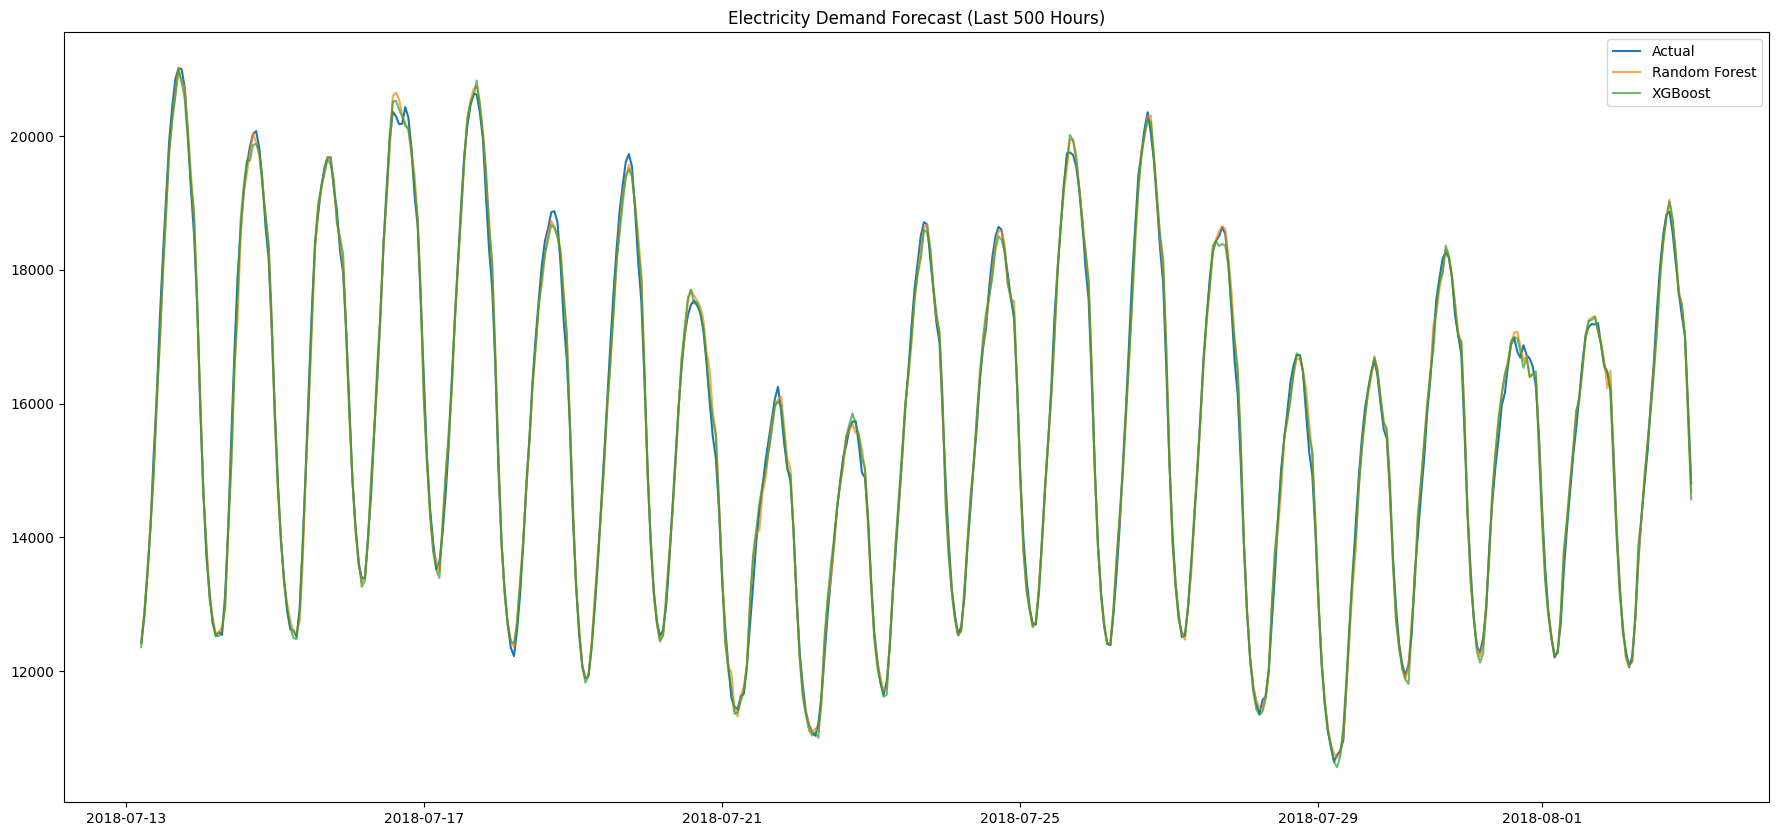

In [19]:
plt.figure(figsize=(22,10))
plt.plot(y_test.index[-500:], y_test[-500:], label="Actual")
# plt.plot(y_test.index[-500:], baseline_pred[-500:], label="Baseline", alpha=0.7)
plt.plot(y_test.index[-500:], y_pred_rf[-500:], label="Random Forest", alpha=0.7)
plt.plot(y_test.index[-500:], y_pred_xgb[-500:], label="XGBoost", alpha=0.7)
plt.legend()
plt.title("Electricity Demand Forecast (Last 500 Hours)")
plt.show()


In [22]:
results = {
    "Model": ["Baseline","RandomForestRegressor","XGBRegressor"],
    "MAE": [base_mae,rf_mae,xgb_mae],
    "RMSE": [base_rmse,rf_rmse,xgb_rmse]
}

results_df = pd.DataFrame(results)
print(results_df)

                   Model         MAE         RMSE
0               Baseline  921.115759  1221.089639
1  RandomForestRegressor  153.491821   207.213847
2           XGBRegressor  136.884591   183.316656


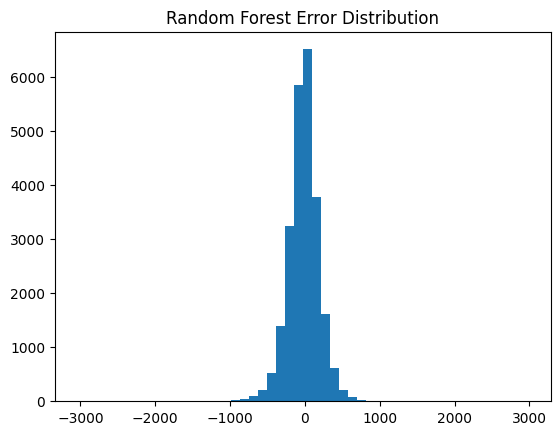

In [24]:
errors_rf = y_test - y_pred_rf
plt.hist(errors_rf,bins= 50)
plt.title("Random Forest Error Distribution")
plt.show() 

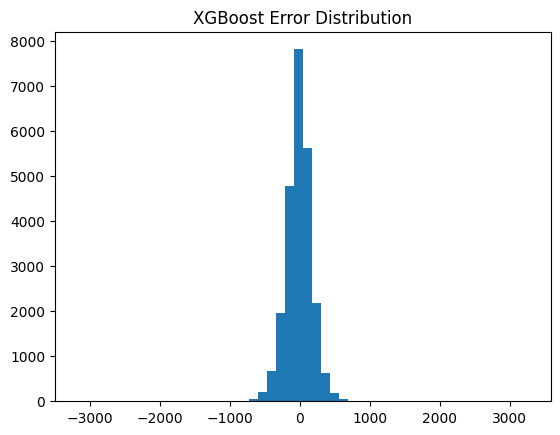

In [26]:
errors_xg = y_test - y_pred_xgb
plt.hist(errors_xg,bins= 50)
plt.title("XGBoost Error Distribution")
plt.show() 

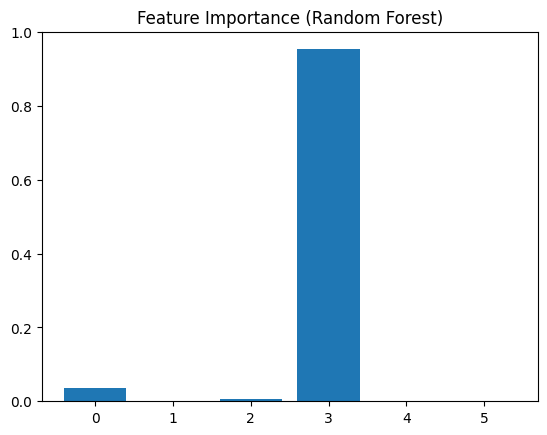

In [28]:
importances_rf = rf.feature_importances_
plt.bar(range(len(importances_rf)), importances_rf)
plt.title("Feature Importance (Random Forest)")
plt.show()


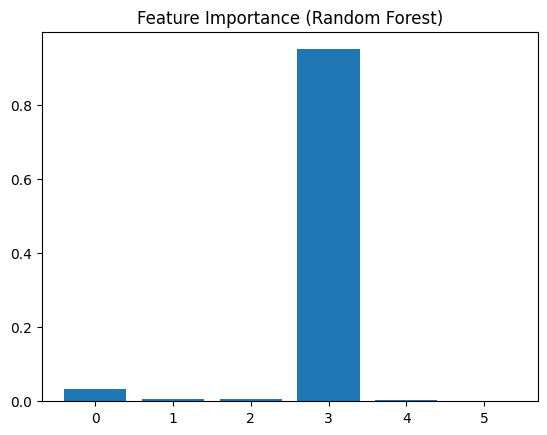

In [29]:
importances_xgb = xgb.feature_importances_
plt.bar(range(len(importances_xgb)), importances_xgb)
plt.title("Feature Importance (Random Forest)")
plt.show()